In [1]:
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np


from matplotlib import cm

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
dataset = pd.read_csv('wine.data')

X = dataset.iloc[:,1:13].values
y = dataset.iloc[:,0].values
X

array([[13.2 ,  1.78,  2.14, ...,  4.38,  1.05,  3.4 ],
       [13.16,  2.36,  2.67, ...,  5.68,  1.03,  3.17],
       [14.37,  1.95,  2.5 , ...,  7.8 ,  0.86,  3.45],
       ...,
       [13.27,  4.28,  2.26, ..., 10.2 ,  0.59,  1.56],
       [13.17,  2.59,  2.37, ...,  9.3 ,  0.6 ,  1.62],
       [14.13,  4.1 ,  2.74, ...,  9.2 ,  0.61,  1.6 ]])

In [3]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X)

In [4]:
from sklearn.cluster import KMeans
kMeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_kMeans = kMeans.fit_predict(X)

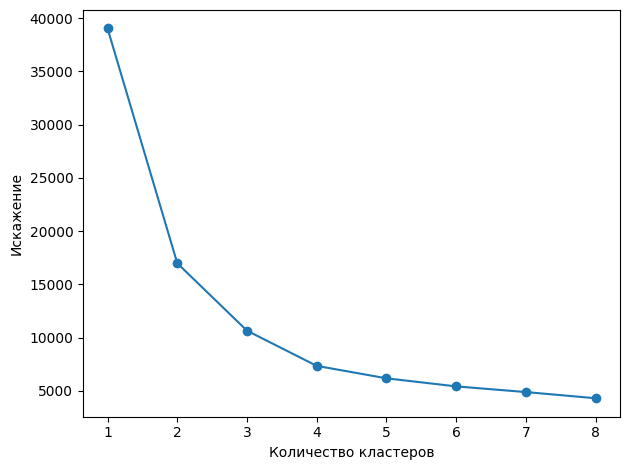

In [5]:
#метод локтя
distortions = []
for i in range(1, 9):
    km = KMeans(n_clusters=i, init='k-means++', n_init=8, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Искажение')
plt.tight_layout()
plt.show();

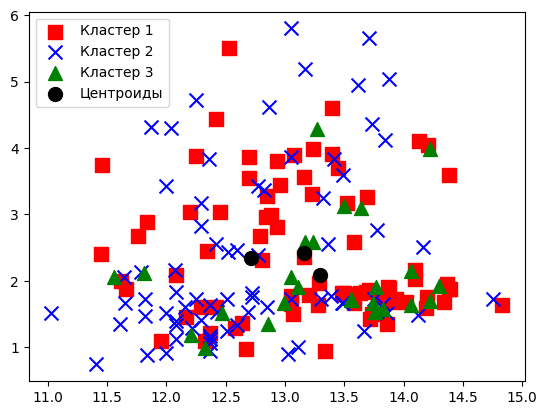

In [6]:
plt.scatter(X[y_kMeans == 0, 0], X[y_kMeans == 0, 1], s=100, c='red', marker = 's', label='Кластер 1')
plt.scatter(X[y_kMeans == 1, 0], X[y_kMeans == 1, 1], s=100, c='blue', marker = 'x', label='Кластер 2')
plt.scatter(X[y_kMeans == 2, 0], X[y_kMeans == 2, 1], s=100, c='green', marker = '^', label='Кластер 3')
plt.scatter(kMeans.cluster_centers_[:, 0], kMeans.cluster_centers_[:,1], s=100, c='black', label='Центроиды')
plt.legend()
plt.show()

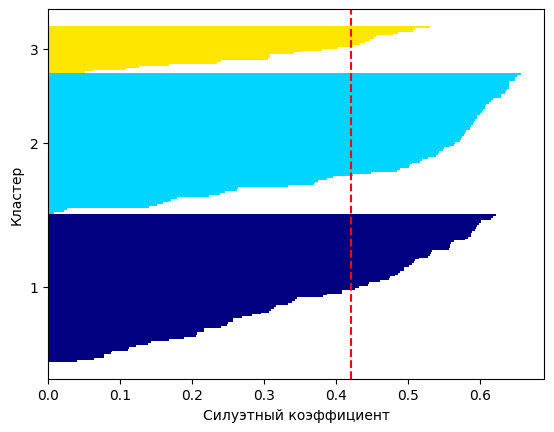

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = np.unique(y_kMeans)
clusters_n = cluster_labels.shape[0]
silh_vals = silhouette_samples(X, y_kMeans, metric='euclidean')
y_ax_lower, y_ax_upper =0, 0
yticks =[]
for i, c in enumerate(cluster_labels):
    c_silh_vals=silh_vals[y_kMeans ==c]
    c_silh_vals.sort()
    y_ax_upper += len(c_silh_vals)
    color = cm.jet(float(i)/clusters_n)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silh_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2)
    y_ax_lower +=len(c_silh_vals)
silh_avg = np.mean(silh_vals)
plt.axvline(silh_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels+1)
plt.ylabel('Кластер')
plt.xlabel('Силуэтный коэффициент')
plt.show()


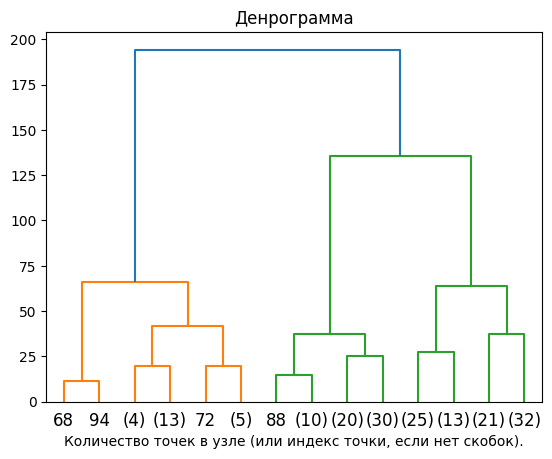

In [8]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def dendrogram_plot(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title('Денрограмма')
dendrogram_plot(model, truncate_mode='level', p=3)
plt.xlabel('Количество точек в узле (или индекс точки, если нет скобок).')
plt.show()

In [9]:
X, labels_true = X[:, [0, 1]], y

db = DBSCAN(eps=0.4, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [10]:
print("Предпологаемое количество кластеров: %d" % n_clusters_)
print("Примерное количество точек шума: %d" % n_noise_)
print("Однородность: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Полнота: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Скорректированный индекс Rand: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Скорректированная взаимная информация: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Коэффицент силуэта: %0.3f" % metrics.silhouette_score(X, labels))

Предпологаемое количество кластеров: 3
Примерное количество точек шума: 57
Однородность: 0.175
Полнота: 0.187
V-measure: 0.181
Скорректированный индекс Rand: 0.154
Скорректированная взаимная информация: 0.166
Коэффицент силуэта: 0.048


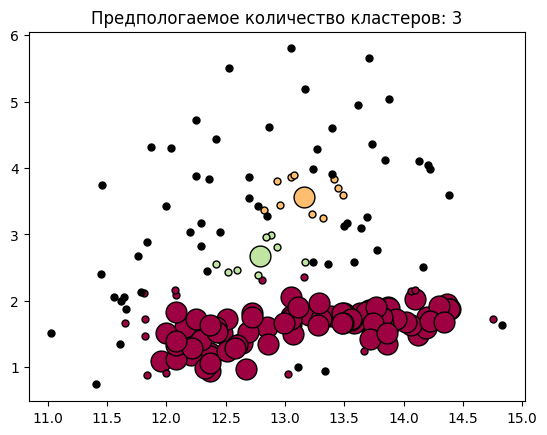

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=15)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=5)

plt.title(f"Предпологаемое количество кластеров: {n_clusters_}")
plt.show()